# <center>ASTR4004/8004 - Simulations - Part 3</center>

This notebook builds a simple 2D Monte Carlo Radiative Transfer simulation, based on the following pseudocode:

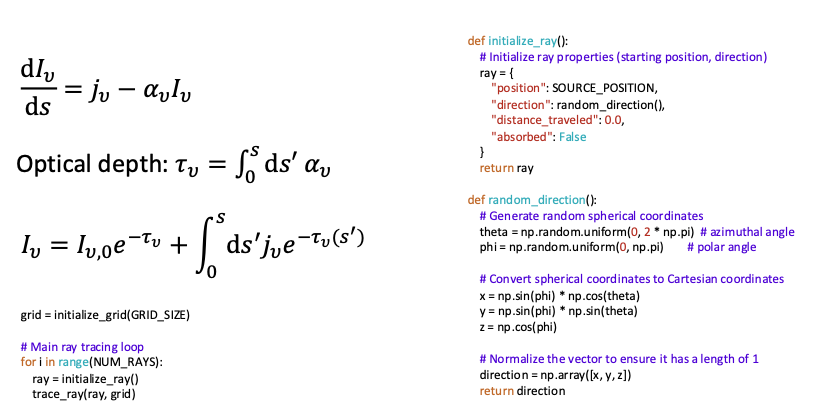

## Useful packages

In [ ]:
import matplotlib
%matplotlib ipympl
#%matplotlib inline
#from IPython.display import HTML
#matplotlib.rcParams['animation.embed_limit'] = 100

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
#plt.rcParams["animation.html"] = "jshtml"

Here, Let's make a couple of setups and assumptions:
* We will fix our source in the center with a radius of `SOUR_RADIUS`.
* We will also fix the gas / sink to have a maximum radius of `SINK_RADIUS` and define a density profile (`den`) such as uniform or normalized Gaussian with the centre truncated due to the source. 
* Let's fix our donut domain in 2D polar coordination (`r`, `theta`) and split it into `N_RADIAL` (on the radial direction) x `N_ANGULAR` (on the angular direction) cells.
* In each step of the simulation, we will generate a photon packet in a Monte-Carlo fashion (fancy way of saying we will shoot the packet in a random direction). The polar coordination makes the photon propogation algorithmically easy, as we only need to increment `r` cell by cell and fix `theta`.
* We will define `N_PHOTONS` as the number of photon packets needed to ionize the entire domain when recommbination is ignored. Therefore, each photon packet has an intial total energy of `ION_EFF` = $\pi$(`SINK_RADIUS^2` - `SOUR_RADIUS^2`) * mean(`den`) / `N_PHOTONS`. We also assume ionizing photons can travel freely inside ionized gas ($\tau=0$) and completely absorbed in neutral gas ($\tau=\infty$).
* We will also consider recombination (`REC_RATE`), which scales proportional to the ionized fraction ($x_{\rm HII}$) squared and density, and hence increases the neutral fraction ($x_{\rm HI}$) by `REC_RATE`* `den` * $x_{\rm HII}^2$.

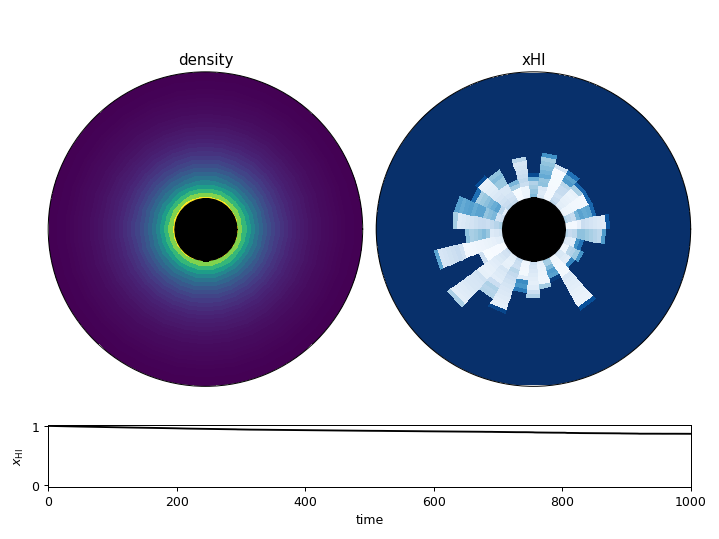

In [ ]:
def rt(SOUR_RADIUS=20, SINK_RADIUS=100, N_RADIAL=100, N_ANGULAR=36, N_PHOTONS=100, REC_RATE=1e-2, TIME_STEP=1000):
    
    """
    Simulation Parameters: 
    
    SOUR_RADIUS:  Radius of the source
    SINK_RADIUS:  Maximum radius of the grid (in arbitrary units)
    N_RADIAL:     Number of radial grid points
    N_ANGULAR:    Number of angular grid points (degrees)
    N_PHOTONS:    Number of packets needed to ionize the entire area
    REC_RATE:     Recombination rate coefficient

    TIME_STEP:    Number of calculation steps
    """
    
    # Visualization
    global xHI, den

    # Cell Geometry
    dr = ...
    dtheta = ...
    cell_area = ...

    # Using pcolormesh to create a polar plot
    r_edges     = np.linspace(SOUR_RADIUS, SINK_RADIUS, N_RADIAL+1)
    theta_edges = np.linspace(0, np.pi*2, N_ANGULAR+1)
    R_edges, Theta_edges = np.meshgrid(r_edges, theta_edges, indexing='ij')

    xHI = np.ones((N_RADIAL, N_ANGULAR))  # 1: Neutral, 0: Ionized
    den = np.ones((N_RADIAL, N_ANGULAR))  # uniform hydrogen density

    ## Explore different gas distribution
    #den[:,:10] += 10 # add a dense patch
    #den /= np.average(np.average(den, axis=1), weights=cell_area) # normalize density so the mean is 1

    den = np.exp(-(R_edges)**0.5)
    den /= np.average(np.average(den, axis=1), weights=np.insert(cell_area,0, (SOUR_RADIUS - 0.5*dr) * dr * dtheta)) # normalize density so the mean is 1
    
    # Plot ionization on the top in polar projection
    fig = plt.figure(figsize=(8, 6), constrained_layout=True)
    gs  = GridSpec(2, 2, height_ratios=[7, 1], width_ratios=[1, 1], figure=fig)

    ax_den = fig.add_subplot(gs[0, 0], projection='polar')  # top-left  (Density)
    ax_xHI = fig.add_subplot(gs[0, 1], projection='polar') # top-right (xHI)
    ax_evo = fig.add_subplot(gs[1, :])                      # bottom spans both
    
    ax_den.pcolormesh(Theta_edges,R_edges, den, cmap='viridis')
    ax_den.set_title('density')
    
    mesh = ax_xHI.pcolormesh(Theta_edges,R_edges, xHI, cmap='Blues', vmin=0, vmax=1)
    ax_xHI.set_title('xHI')
    for ax in [ax_den, ax_xHI]:
        ax.grid(False)
        ax.set_rticks([])
        ax.set_xticks([])
        ax.fill_between(theta_edges, np.full_like(theta_edges, SOUR_RADIUS), color='black')

    # plot the neutral hydrogen fraction in the bottom to trace ionizing progress.
    time_data = [0, ]
    xHIs_data = [1, ]
    evo_plot, = ax_evo.plot(time_data, xHIs_data, color='k')
    ax_evo.set_ylabel(r'$x_{\rm HI}$')
    ax_evo.set_xlabel(r'time')
    ax_evo.set_ylim(-0.02,1.02)
    ax_evo.set_xlim(0, TIME_STEP)

    plt.tight_layout()
    
    def evolve(it):
        global xHI, den
        
        # Initialize photon at the edge of the source
        los_step  = ...
        theta_pos = ...
        ION_EFF   = ...
        
        while ...:
                            
            if xHI[los_step, theta_pos] * den[los_step,theta_pos] * area > ION_EFF:
                # completely absorbed and the gas is partially ionized
                ...
                
            else:
                # partially absorbed and the gas is completely ionized
                ...

        # Now let's do recombination
        for los_step in range(N_RADIAL):               
            for theta_pos in range(N_ANGULAR):
                ...
                
        xHI = np.clip(xHI, 0, 1) # obviously, you don't want to over-recombine.
        mesh.set_array(xHI)
        
        time_data.append(it)
        xHIs_data.append(np.mean(xHI))
        evo_plot.set_data(time_data, xHIs_data)
    
    anim = FuncAnimation(
        fig,
        evolve,
        frames = Nframe,
        interval = interval,
        blit = True,
        repeat = False,
    )

    return anim

In [ ]:
anim = rt(SOUR_RADIUS=10, # Radius of the source
          SINK_RADIUS=50, # Maximum radius of the grid (in arbitrary units)
          N_RADIAL=30,    # Number of radial grid points
          N_ANGULAR=30,   # Number of angular grid points (degrees)
          N_PHOTONS=500,  # Number of packets needed to ionize the entire area
          REC_RATE=1e-3,  # Recombination rate coefficient
          TIME_STEP=1000) # Number of calculation steps
#plt.close()
#anim